In [1]:
from matplotlib import pyplot as plt
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import imutils
from easyocr import Reader
import cv2
import requests
import numpy as np
import torch
from PIL import ImageFont, ImageDraw, Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()
 
 
def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []
 
  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])
 
  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)
 
  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]
 
  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
  findCnt = None
 
  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break
 
 
  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))
 
 
  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)
 
  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)
 
  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)
 
  return transform_image

In [4]:
def putText(cv_img, text, x, y, color=(0, 0, 0), font_size=22):
  # Colab이 아닌 Local에서 수행 시에는 gulim.ttc 를 사용하면 됩니다.
  # font = ImageFont.truetype("fonts/gulim.ttc", font_size)
  #font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', font_size)
  font = ImageFont.load_default()
  img = Image.fromarray(cv_img)
   
  draw = ImageDraw.Draw(img)
  draw.text((x, y), text, font=font, fill=color)
 
  cv_img = np.array(img)
  
  return cv_img

C:\Users\white\AppData\Local\Temp\ipykernel_17280\1308564049.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  encoded_img = np.fromstring(data, dtype = np.uint8)


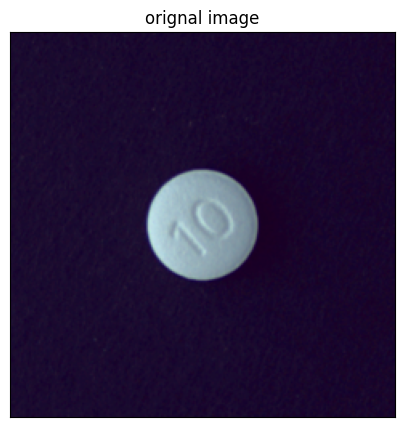

In [5]:
url = 'https://user-images.githubusercontent.com/69428232/155486780-55525c3c-8f5f-4313-8590-dd69d4ce4111.jpg'
path = './DATA/test/에피나레정/K-038884_0_0_1_2_90_260_200.png'

with open(path, 'rb') as f:
    data = f.read()
encoded_img = np.fromstring(data, dtype = np.uint8)
org_image = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR) 
plt_imshow("orignal image", org_image)
 
#business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [6]:
langs = ['en']
 
print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(org_image)

[INFO] OCR'ing input image...


In [7]:
results

[]

In [8]:
simple_results = reader.readtext(org_image, detail = 0)
simple_results

[]

In [9]:
# loop over the results
for (bbox, text, prob) in results:
  print("[INFO] {:.4f}: {}".format(prob, text))
  
  (tl, tr, br, bl) = bbox
  tl = (int(tl[0]), int(tl[1]))
  tr = (int(tr[0]), int(tr[1]))
  br = (int(br[0]), int(br[1]))
  bl = (int(bl[0]), int(bl[1]))
 
	# 추출한 영역에 사각형을 그리고 인식한 글자를 표기합니다.
  cv2.rectangle(org_image, tl, br, (0, 255, 0), 2)
  font = ImageFont.load_default()
  org_image = putText(org_image, text, tl[0], tl[1] - 60, (0, 255, 0), 50)
  #cv2.putText(org_image, text, (tl[0], tl[1] - 10), font, 0.8, (0, 255, 0), 2)

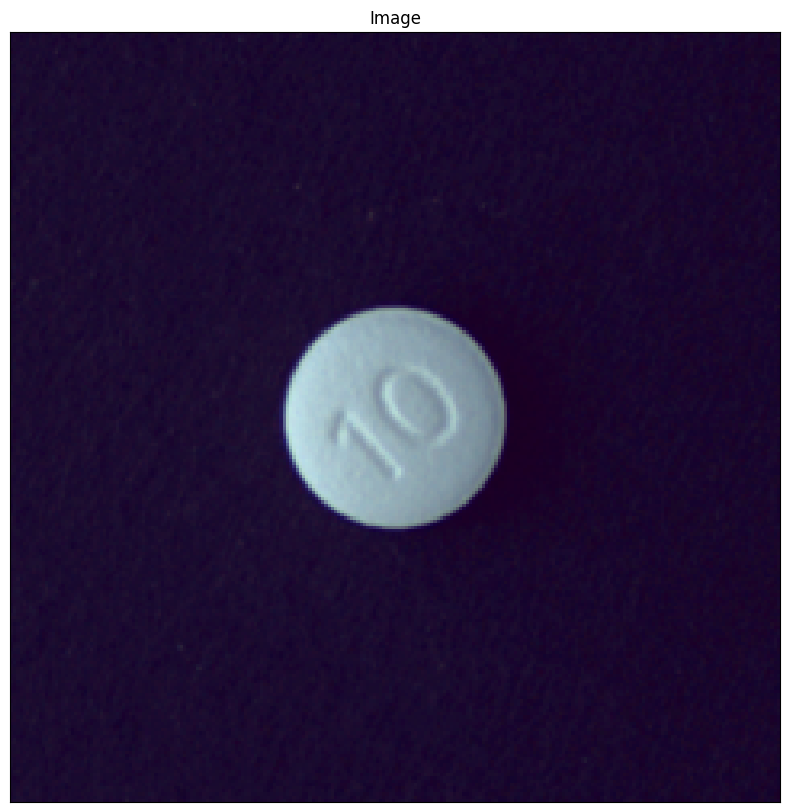

In [10]:
plt_imshow("Image", org_image, figsize=(16,10))

otsu threshold
150.0 91.0 91.0 91.0


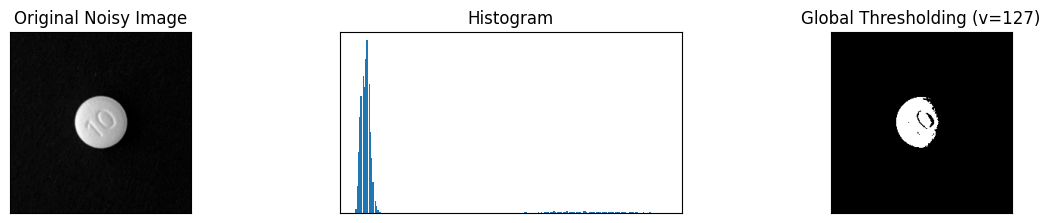

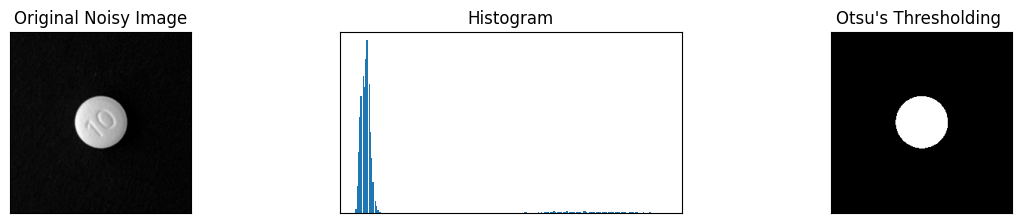

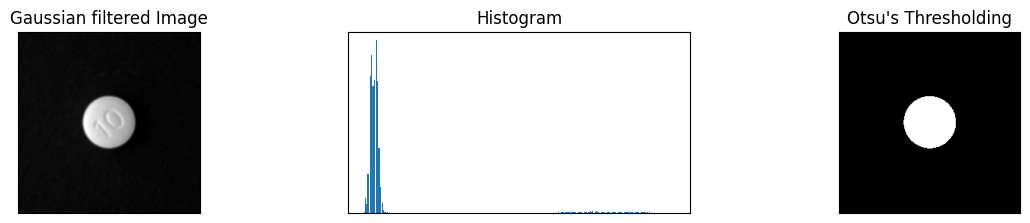

In [11]:
#img = cv2.imread(path,0)
img_array = np.fromfile(path, np.uint8)
img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# global thresholding
ret1, th1 = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)

ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

ret25, th25 = cv2.threshold(img, -1, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

blur = cv2.GaussianBlur(img,(5,5),0)

ret3, th3 = cv2.threshold(img, -1, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print("otsu threshold")
print(ret1,ret2,ret25,ret3)

# plot all the images and their histograms
images = [img, 0, th1, img, 0, th2, blur, 0, th3]

titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)', 'Original Noisy Image','Histogram',"Otsu's Thresholding ", 'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
  plt.figure(figsize=(15,8))
  plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
  plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
  plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
  plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
  plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
  plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])

plt.show()